In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [23]:
df = pd.read_csv('/content/cleaned_f1_data_New.csv')

In [24]:
df.head()

,Season,Round,Race Name,Date,Circuit,Country,Latitude,Longitude,Driver,Driver Nationality,...,Constructor,Constructor Nationality,Grid Position,Race Position,Points Earned,Fastest Lap (s),Fastest Lap Rank,Total Pit Stops,Race Laps Completed,Retirement Status
0,1950,1,British Grand Prix,1950-05-13,Silverstone Circuit,UK,52.0786,-1.01694,Bob Gerard,British,...,ERA,British,13,6,0.0,93.053598,-1,-1,67,Finished
1,1950,1,British Grand Prix,1950-05-13,Silverstone Circuit,UK,52.0786,-1.01694,Cuth Harrison,British,...,ERA,British,15,7,0.0,93.053598,-1,-1,67,Finished
2,1950,1,British Grand Prix,1950-05-13,Silverstone Circuit,UK,52.0786,-1.01694,David Hampshire,British,...,Maserati,Italian,16,9,0.0,93.053598,-1,-1,64,Finished
3,1950,1,British Grand Prix,1950-05-13,Silverstone Circuit,UK,52.0786,-1.01694,Brian Shawe Taylor,British,...,Maserati,Italian,20,10,0.0,93.053598,-1,-1,64,Finished
4,1950,1,British Grand Prix,1950-05-13,Silverstone Circuit,UK,52.0786,-1.01694,Joe Fry,British,...,Maserati,Italian,20,10,0.0,93.053598,-1,-1,64,Finished


In [25]:
to_drop = ['Driver Championship Points','Latitude', 'Longitude','Driver Experience (Years)', 'Driver Fastest Lap Time', 'Driver Fastest Lap Rank', 'Points Earned', 'Fastest Lap (s)', 'Fastest Lap Rank', 'Total Pit Stops','Date','Country','Driver Nationality','Round','Season']
df = df.drop(columns=to_drop, errors='ignore')
df.columns

Index(['Race Name', 'Circuit', 'Driver', 'Driver Age', 'Constructor',
       'Constructor Nationality', 'Grid Position', 'Race Position',
       'Race Laps Completed', 'Retirement Status'],
      dtype='object')

Categorical Values

In [26]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_cols)

categories_list = [df[col].unique().tolist() for col in categorical_cols]

encoder = OrdinalEncoder(categories=categories_list)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

df.head()

Categorical Columns: ['Race Name', 'Circuit', 'Driver', 'Constructor', 'Constructor Nationality', 'Retirement Status']


,Race Name,Circuit,Driver,Driver Age,Constructor,Constructor Nationality,Grid Position,Race Position,Race Laps Completed,Retirement Status
0,0.0,0.0,0.0,36,0.0,0.0,13,6,67,0.0
1,0.0,0.0,1.0,44,0.0,0.0,15,7,67,0.0
2,0.0,0.0,2.0,33,1.0,1.0,16,9,64,0.0
3,0.0,0.0,3.0,35,1.0,1.0,20,10,64,0.0
4,0.0,0.0,4.0,35,1.0,1.0,20,10,64,0.0


Making the target Variable into Categorical

In [27]:
def categorize_positions(df):
    # Create a new column for position category
    df['Position_Category'] = ''

    # Apply conditions for 3 labels
    df.loc[df['Race Position'] <= 10, 'Position_Category'] = 'Top 10'
    df.loc[(df['Race Position'] > 10) & (df['Race Position'] <= 20), 'Position_Category'] = 'Midfield'
    df.loc[df['Race Position'] > 20, 'Position_Category'] = 'Backmarkers'

    return df

In [28]:
df = categorize_positions(df)

Converting all features into one single data type

In [29]:
df[['Driver Age', 'Grid Position', 'Race Laps Completed']]=df[['Driver Age', 'Grid Position', 'Race Laps Completed']].astype(float)

In [30]:
df.head()

,Race Name,Circuit,Driver,Driver Age,Constructor,Constructor Nationality,Grid Position,Race Position,Race Laps Completed,Retirement Status,Position_Category
0,0.0,0.0,0.0,36.0,0.0,0.0,13.0,6,67.0,0.0,Top 10
1,0.0,0.0,1.0,44.0,0.0,0.0,15.0,7,67.0,0.0,Top 10
2,0.0,0.0,2.0,33.0,1.0,1.0,16.0,9,64.0,0.0,Top 10
3,0.0,0.0,3.0,35.0,1.0,1.0,20.0,10,64.0,0.0,Top 10
4,0.0,0.0,4.0,35.0,1.0,1.0,20.0,10,64.0,0.0,Top 10


In [31]:
df.drop('Race Position', axis=1, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Race Name                3616 non-null   float64
 1   Circuit                  3616 non-null   float64
 2   Driver                   3616 non-null   float64
 3   Driver Age               3616 non-null   float64
 4   Constructor              3616 non-null   float64
 5   Constructor Nationality  3616 non-null   float64
 6   Grid Position            3616 non-null   float64
 7   Race Laps Completed      3616 non-null   float64
 8   Retirement Status        3616 non-null   float64
 9   Position_Category        3616 non-null   object 
dtypes: float64(9), object(1)
memory usage: 282.6+ KB


In [33]:
position_encoded = {'Top 10': 0, 'Midfield': 1, 'Backmarkers': 2}
df['Position_Category'] = df['Position_Category'].map(position_encoded)

In [34]:
X=df.drop(['Position_Category'],axis=1)
y=df['Position_Category']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Before Transformation

In [36]:
X_train_df = pd.DataFrame(X_train)
print(X_train_df)

      Race Name  Circuit  Driver  Driver Age  Constructor  \
2592       11.0     22.0   425.0        31.0        125.0   
3216        6.0      7.0   473.0        28.0          5.0   
1228        4.0      4.0   262.0        28.0         42.0   
1234        7.0      8.0   306.0        26.0         87.0   
794         1.0      1.0   222.0        27.0         46.0   
...         ...      ...     ...         ...          ...   
1130       10.0     17.0   237.0        33.0         73.0   
1294        7.0      8.0   315.0        29.0         89.0   
860         8.0     11.0   261.0        28.0         70.0   
3507       10.0     28.0   509.0        22.0        114.0   
3174       17.0     13.0   482.0        24.0        134.0   

      Constructor Nationality  Grid Position  Race Laps Completed  \
2592                      5.0           17.0                 56.0   
3216                      1.0            4.0                  0.0   
1228                      0.0            2.0                

Scaling Features

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

After Transformation

In [38]:
original_column_names = X.columns
X_train_df = pd.DataFrame(X_train, columns=original_column_names)
X_train_df.head()
print(X_train_df)

      Race Name   Circuit    Driver  Driver Age  Constructor  \
0      0.633143  0.940873  0.744424    0.065303     1.118686   
1     -0.414009 -0.713903  1.100863   -0.561431    -1.638465   
2     -0.832870 -1.044859 -0.465982   -0.561431    -0.788343   
3     -0.204578 -0.603585 -0.139247   -0.979254     0.245589   
4     -1.461161 -1.375814 -0.763014   -0.770343    -0.696438   
...         ...       ...       ...         ...          ...   
2887   0.423713  0.389281 -0.651627    0.483126    -0.076079   
2888  -0.204578 -0.603585 -0.072414   -0.352520     0.291541   
2889   0.004852 -0.272630 -0.473408   -0.561431    -0.145008   
2890   0.423713  1.602783  1.368192   -1.814900     0.865948   
2891   1.889725 -0.051993  1.167695   -1.397077     1.325473   

      Constructor Nationality  Grid Position  Race Laps Completed  \
0                    1.305564       0.609343             0.631105   
1                   -0.136640      -1.123028            -1.273713   
2                   -0.4

In [39]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Classifier
Accuracy: 0.8660220994475138
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       182
           1       0.83      0.90      0.86       341
           2       0.85      0.80      0.82       201

    accuracy                           0.87       724
   macro avg       0.88      0.86      0.87       724
weighted avg       0.87      0.87      0.87       724



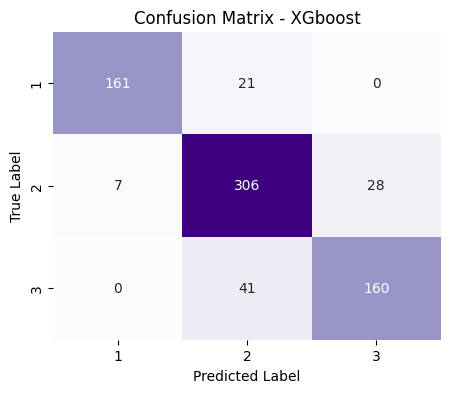

In [42]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)


plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
plt.title("Confusion Matrix - XGboost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Random Forest

In [43]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Feature: Race Name, Importance: 0.0452
Feature: Circuit, Importance: 0.0530
Feature: Driver, Importance: 0.1077
Feature: Driver Age, Importance: 0.0474
Feature: Constructor, Importance: 0.0604
Feature: Constructor Nationality, Importance: 0.0310
Feature: Grid Position, Importance: 0.0884
Feature: Race Laps Completed, Importance: 0.2337
Feature: Retirement Status, Importance: 0.3332


<ipython-input-44-eb41237b1d8f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, palette="viridis")


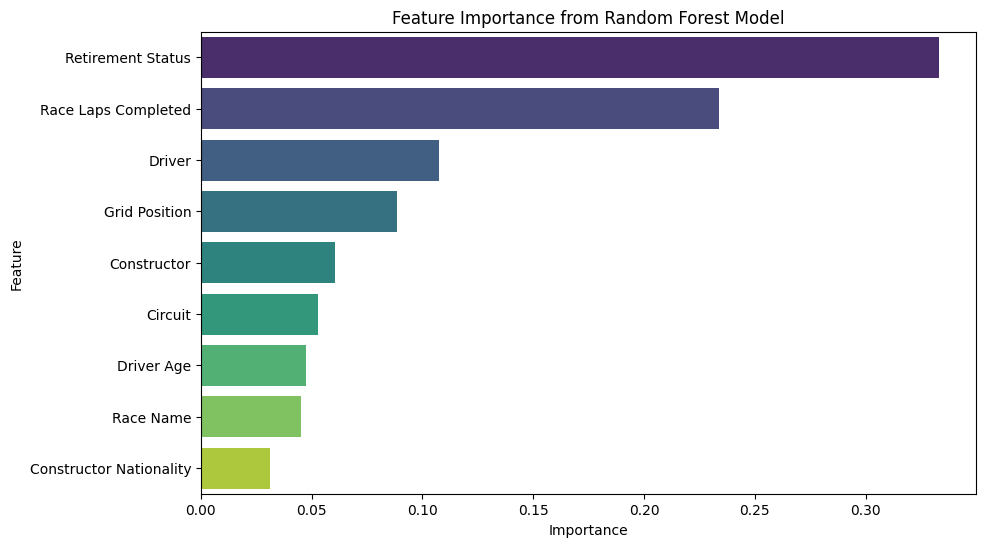

In [44]:
importances = rf_model.feature_importances_

# 3. Match importances to your feature names
feature_names = X.columns
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

# 4. Visualize nicely
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for plotting
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette="viridis")
plt.title('Feature Importance from Random Forest Model')
plt.show()

In [45]:
# Predict on test data
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest
Accuracy: 0.8577348066298343
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       182
           1       0.82      0.90      0.86       341
           2       0.85      0.79      0.82       201

    accuracy                           0.86       724
   macro avg       0.88      0.85      0.86       724
weighted avg       0.86      0.86      0.86       724



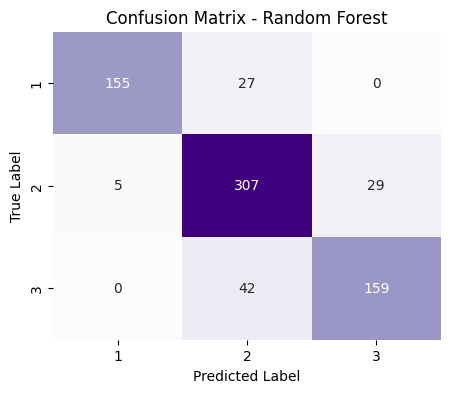

In [46]:
cm_rf = confusion_matrix(y_test, y_pred_rf)


plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples", cbar=False,
            xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()